In [177]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import heapq

In [178]:
class Graph:
    def __init__(self):
        self.vertices = {}
        self.steiner_vertices = []
        self.optimal_cost_steiner_tree = 0
    
    def set_optimal_cost_steiner_tree(self,cost):
        self.optimal_cost_steiner_tree = cost
    
    def get_optimal_cost_steiner_tree(self):
        return self.optimal_cost_steiner_tree

    def add_vertex(self, vertex):
        self.vertices[vertex] = {}
        
    def add_steiner(self,vertex):
        self.steiner_vertices.append(vertex)

    def add_edge(self, vertex1, vertex2, weight):
        if vertex1 not in self.vertices:
            self.add_vertex(vertex1)
        if vertex2 not in self.vertices:
            self.add_vertex(vertex2)

        self.vertices[vertex1][vertex2] = weight
        self.vertices[vertex2][vertex1] = weight

    def get_neighbors(self, vertex):
        return self.vertices[vertex]
    
    def get_vertices(self):
        return list(self.vertices.keys())
    
    def get_steiner_vertices(self):
        return self.steiner_vertices
    
    def get_edges(self):
        edges = []
        for vertex in self.vertices:
            neighbors = self.get_neighbors(vertex)
            for neighbor in neighbors:
                # Add edge to the list as a tuple
                edges.append((vertex, neighbor))
        return edges
    
    def get_weight(self, vertex1, vertex2):
        if vertex1 in self.vertices and vertex2 in self.vertices[vertex1]:
            return self.vertices[vertex1][vertex2]
        else:
            return None
    
    def calculate_cost(graph):
        cost = 0
        edges = graph.get_edges()
        visited = []
        
        for edge in edges:
            vertex1, vertex2 = edge
            if (vertex1,vertex2) in visited or (vertex2, vertex1) in visited:
                continue
            weight = graph.get_weight(vertex1, vertex2)
            if weight is not None:
                cost += weight
            visited.append(edge)
        return cost
        
    def draw_graph(self):
        nx_graph = nx.Graph()
        for vertex, neighbors in self.vertices.items():
            for neighbor, weight in neighbors.items():
                nx_graph.add_edge(vertex, neighbor, weight=weight)

        # Disegno del grafo
        pos = nx.circular_layout(nx_graph)


        # Draw the graph with terminals in red and Steiner tree edges in blue
        nx.draw_networkx(nx_graph, pos, with_labels=True, node_color='lightgray', node_size=500)
        nx.draw_networkx_labels(nx_graph, pos)
        nx.draw_networkx_nodes(nx_graph, pos, nodelist = self.steiner_vertices, node_color='#e3a5b0', node_size=500)
        edge_labels = nx.get_edge_attributes(nx_graph, 'weight')
        #nx.draw_networkx_edges(steiner_tree, pos, edge_color='blue', width=2)
        nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels = edge_labels, font_size=10)


        # Visualizzazione del grafo
        #plt.axis('off')
        #plt.show()
        
    def find_shortest_path(self, start_node, end_node):
        distances = {vertex: float('inf') for vertex in self.vertices}
        distances[start_node] = 0
        visited = set()
        previous = {}
        edge_weights = {}

        priority_queue = [(0, start_node)]

        while priority_queue:
            current_distance, current_node = heapq.heappop(priority_queue)

            if current_node == end_node:
                path = {}
                current_edge = (end_node, previous[end_node])
                while current_node in previous:
                    #Aggiungo al percorso l'arco con il peso corrispondente
                    path[current_edge] = edge_weights[current_edge]
                    current_node = previous[current_node]
                    if current_node in previous:
                        current_edge = (current_node, previous[current_node])
                return path
            visited.add(current_node)

            neighbors = self.get_neighbors(current_node)
            for neighbor, weight in neighbors.items():
                if neighbor in visited:
                    continue

                new_distance = current_distance + weight
                if new_distance < distances[neighbor]:
                    distances[neighbor] = new_distance
                    previous[neighbor] = current_node
                    edge_weights[(neighbor, current_node)] = weight
                    heapq.heappush(priority_queue, (new_distance, neighbor))
      
        #Se arrivo qui non sono riuscita a collegare il nodo finale
        return previous, edge_weights, distances

In [179]:
#Funzione per disegnare il grafo con il suo corrispondente steiner tree sovrapposto
def draw_with_steiner_tree(grafo_originale, steiner_tree):
    nx_graph = nx.Graph()
    for vertex, neighbors in grafo_originale.vertices.items():
        for neighbor, weight in neighbors.items():
            nx_graph.add_edge(vertex, neighbor, weight=weight)

    # Disegno del grafo -> layout circolare per poterlo vedere bene
    pos = nx.circular_layout(nx_graph)

    # Disegno dei nodi grigi ( non di steiner) con label nome
    nx.draw_networkx(nx_graph, pos, with_labels=True, node_color='lightgray', node_size=500)
    nx.draw_networkx_labels(nx_graph, pos)
    
    #Disegno degli archi presi nello steiner tree 
    steiner_edges = steiner_tree.get_edges()
    steiner_subgraph = nx_graph.edge_subgraph(steiner_edges)
    nx.draw_networkx_edges(steiner_subgraph, pos, edge_color='blue', width=2)
    
    #Disegno dei nodi terminals (in rosa) con label nome
    nx.draw_networkx_nodes(nx_graph, pos, nodelist = steiner_tree.get_steiner_vertices(), node_color='#e3a5b0', node_size=500)
    
    #Disegno dei pesi sugli archi
    edge_labels = nx.get_edge_attributes(nx_graph, 'weight')
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels = edge_labels, font_size=10)
    
    #Disegno dei pesi degli archi di steiner con colore diverso
    edge_labels_steiner = {}
    for edge in edge_labels:
        if edge in steiner_edges:
            edge_labels_steiner[edge] = edge_labels[edge]
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels = edge_labels_steiner, font_size=10, font_color = 'blue')

    # Visualizzazione del grafo
    #plt.axis('off')
    #plt.show()

In [180]:
#Grafo di partenza su cui calcolare le distanze, nodo di partenza, nodi rispetto a cui mi interessa calcolare la distanza
def dijkstra(graph, start, steiner_tree):
    distances = {node: float('inf') for node in graph.get_vertices()}  # Initialize distances to infinity
    distances[start] = 0  # Distance from start node to itself is 0
    priority_queue = [(0, start)]  # Use a priority queue to prioritize nodes with shorter distances
    visited = set()  # Set to track visited nodes
    found_nodes = set()  # Set to track found target nodes
    
    while priority_queue and found_nodes != set(steiner_tree.get_vertices()):
        current_distance, current_node = heapq.heappop(priority_queue)  # Get the node with the smallest distance
        
        # Skip if we have already found a shorter path to the current node
        if current_distance > distances[current_node]:
            continue
        
        visited.add(current_node)  # Mark current node as visited
        
        # Check if the current node is a target node
        if current_node in steiner_tree.get_vertices():
            found_nodes.add(current_node)
        
        #Explore neighbors of the current node
        neighbors = graph.get_neighbors(current_node)
        for neighbor, weight in neighbors.items():
            if neighbor in visited:
                continue  # Skip already visited neighbors
            distance = current_distance + weight
            if distance < distances[neighbor]:  # If a shorter path is found, update the distance
                distances[neighbor] = distance
                heapq.heappush(priority_queue, (distance, neighbor))  # Add the neighbor to the priority queue
    result_distances = {}
    for i in distances:
        if i in steiner_tree.get_vertices():
            result_distances[i] = distances[i]
        
    
    return result_distances

In [181]:
def shortest_path(grafo):
    steiner_tree = Graph()
    terminals = (grafo.get_steiner_vertices()).copy()
    
    #Estraggo il primo dei terminali e lo inserisco nel risultato
    first_node = terminals.pop(0)
    steiner_tree.add_vertex(first_node)
    steiner_tree.add_steiner(first_node)
    
    #Finchè ho dei nodi terminali da inserire nell'albero
    while len(terminals) > 0:
        #1) Trovo il nodo di steiner che ha la distanza minore dallo steiner tree attuale 
        # (Controllo Djikstra da ogni nodo terminal rispetto a tutti i nodi (dello steiner tree))
        terminals_distances = {}
        i = 0 
        #Controllo con dijkstra tutte le distanze
        for i in range(0, len(terminals)):
            result_dijkstra = dijkstra(grafo, terminals[i], steiner_tree)
            #Trovo il nodo con cui il terminale ha la distanza minima
            minimum_key, minimum_distance = min(result_dijkstra.items(), key=lambda x: x[1])
            terminals_distances[terminals[i]] = {minimum_key : minimum_distance}
        
        #Trovo quale terminale è più vicino all'albero
        minimum_value = min(terminals_distances.values(), key=lambda x: next(iter(x.values())))
        minimum_node = []
        for key, val in terminals_distances.items():
            if val == minimum_value:
                minimum_node.append(key)
        #Nodo a distanza minima, distanza dal nodo, terminals da attaccare
        nodo_di_attacco = list(minimum_value.items())[0][0]
        distanza_di_attacco = list(minimum_value.items())[0][1]
        nodo_terminal_da_aggiungere = minimum_node[0]
        
        #2) Attacco il nodo - Trovo il shortest path tra i il terminal e il nodo più vicino dell'albero
        path = grafo.find_shortest_path(nodo_di_attacco,nodo_terminal_da_aggiungere)
        #Aggiungo il percorso al grafo di steiner
        for edge in path:
            steiner_tree.add_edge(edge[0],edge[1],path[edge])
            
        #Rimuovo dalla lista il terminale aggiunto
        terminals.remove(nodo_terminal_da_aggiungere)
        steiner_tree.add_steiner(nodo_terminal_da_aggiungere)
    
    return steiner_tree
    
    

Costo grafo originale:  45


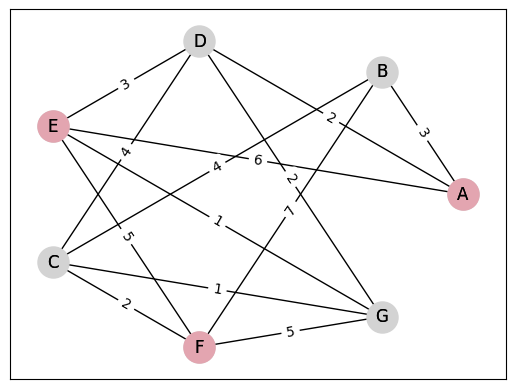

In [182]:
graphh = Graph()
graphh.add_edge('A', 'B', 3)
graphh.add_edge('A', 'D', 2)
graphh.add_edge('A', 'E', 6)
graphh.add_edge('D', 'C', 4)
graphh.add_edge('D', 'E', 3)
graphh.add_edge('D', 'G', 2)
graphh.add_edge('E', 'F', 5)
graphh.add_edge('E', 'G', 1)
graphh.add_edge('G', 'F', 5)
graphh.add_edge('G', 'C', 1)
graphh.add_edge('C', 'F', 2)
graphh.add_edge('B', 'C', 4)
graphh.add_edge('F', 'B', 7)
graphh.add_steiner('A')
graphh.add_steiner('E')
graphh.add_steiner('F')

graphh.draw_graph()



print("Costo grafo originale: ", graphh.calculate_cost())



#TO DO
1) Mettere i grafici su una stessa riga (grafo originale, sovrapposto, steiner) e aggiungere il costo direttamente sul grafo
2) Controllare meglio come tenere nella struttura i nodi terminals e come aggiungerli nella funzione shortest path
3) Commmentare il codice
4) Fare il controllo dell'ammissibilità del codice! (no cicli e tutti i terminals in soluzione)
5) Misurare il tempo

---------------------
4) Controllare che tutto funzioni con più istanze (meglio leggerle direttamente da csv)
5) Prendere qualcuna delle istanze della pace challenge e fare le funzioni per leggere da csv
6) Trovare una prova di NON ottimalità :)



Istanza:  ./Istanze/instance002.gr
Costo raggiunto dall'euristica: 115
Costo ottimale: 111


Istanza:  ./Istanze/instance006.gr
Costo raggiunto dall'euristica: 557
Costo ottimale: 15


Istanza:  ./Istanze/instance001_t2.gr
Costo raggiunto dall'euristica: 1169
Costo ottimale: 1086


Istanza:  ./Istanze/instance002_t2.gr
Costo raggiunto dall'euristica: 640
Costo ottimale: 626


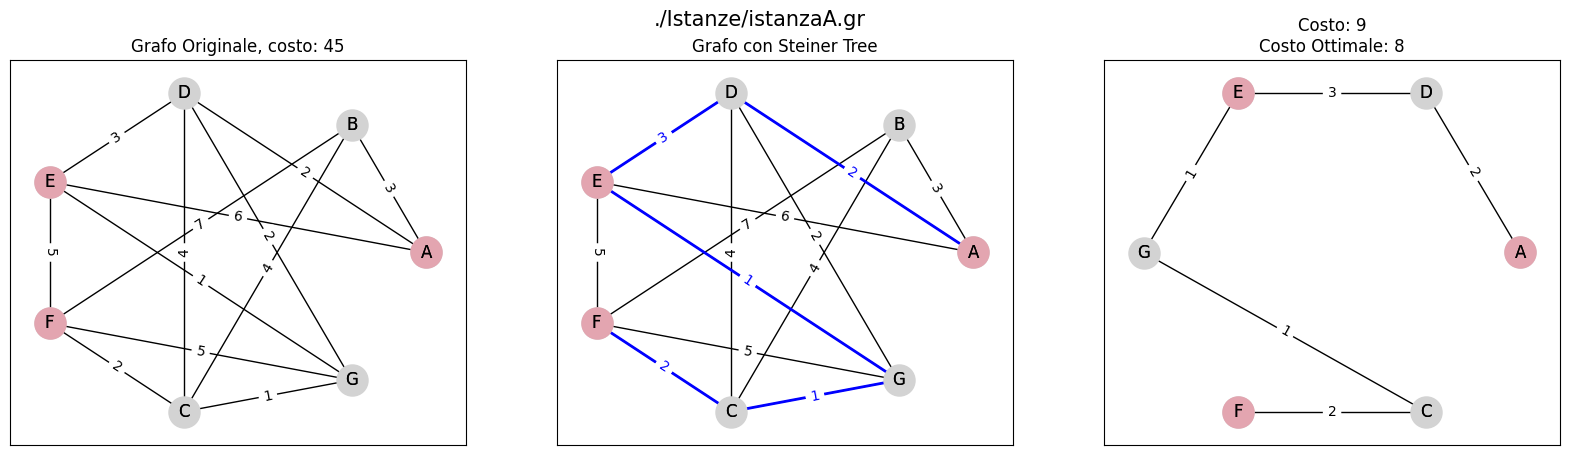

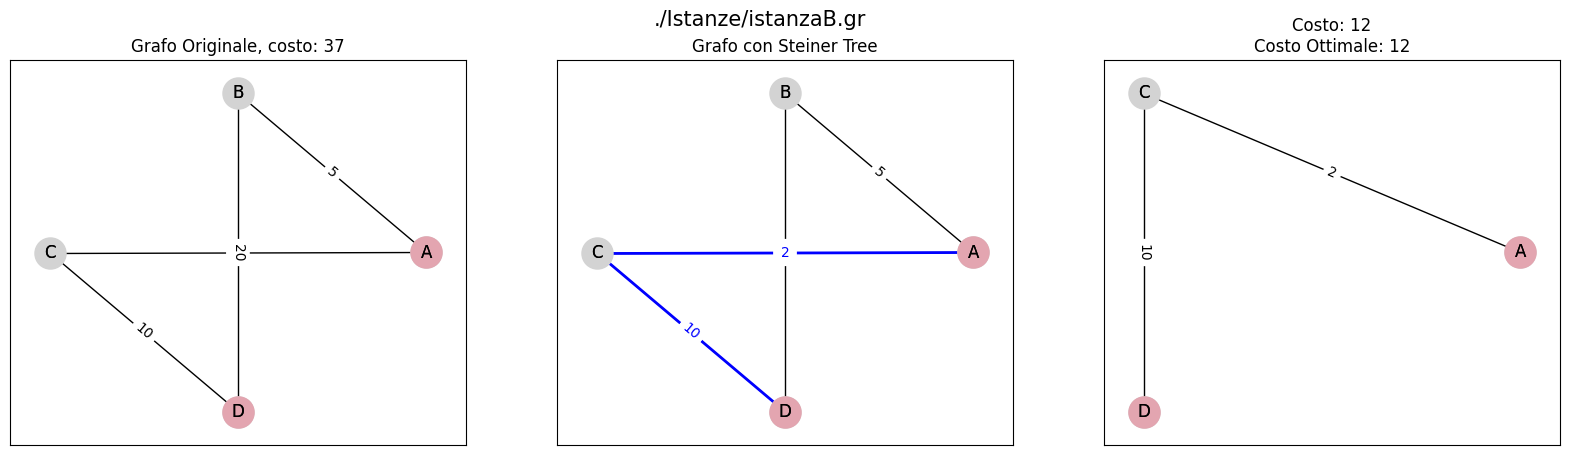

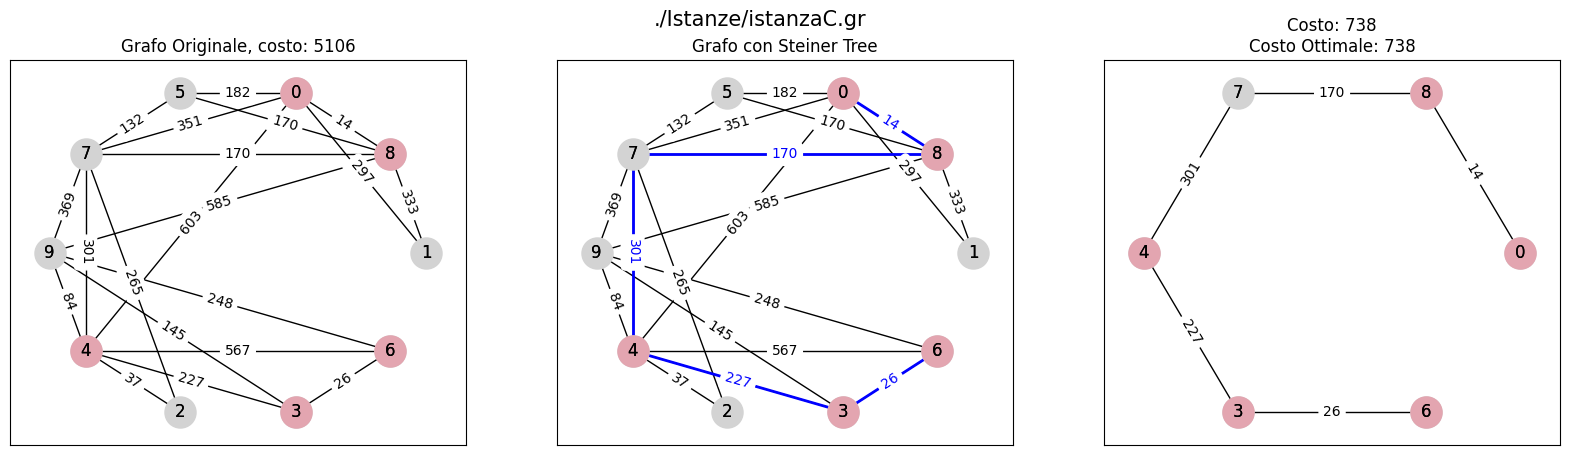

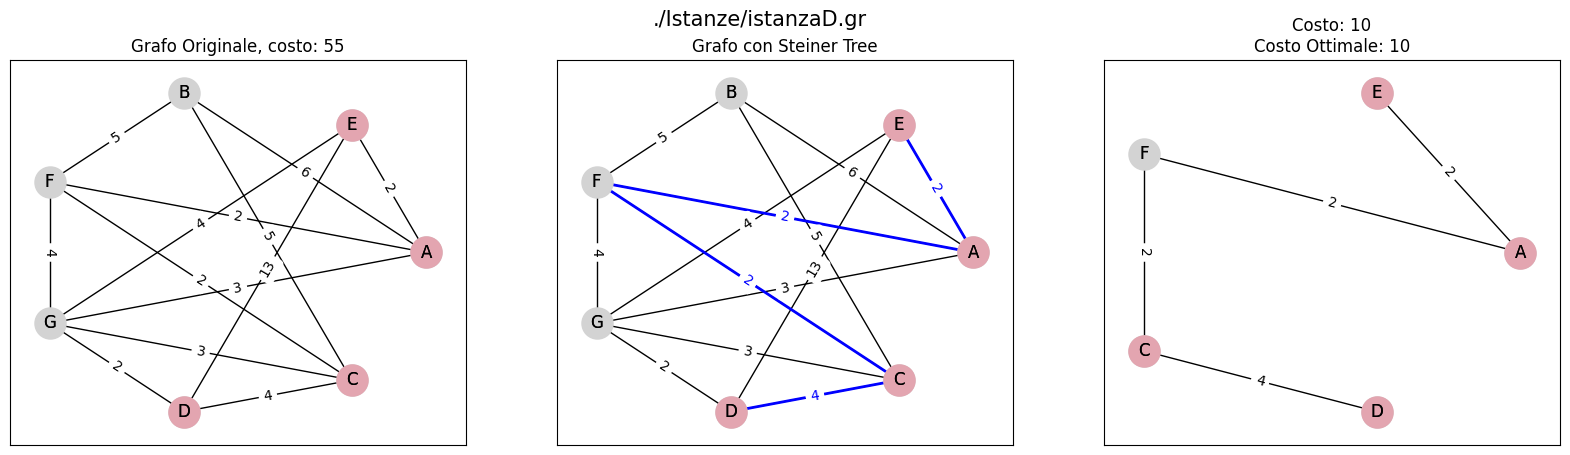

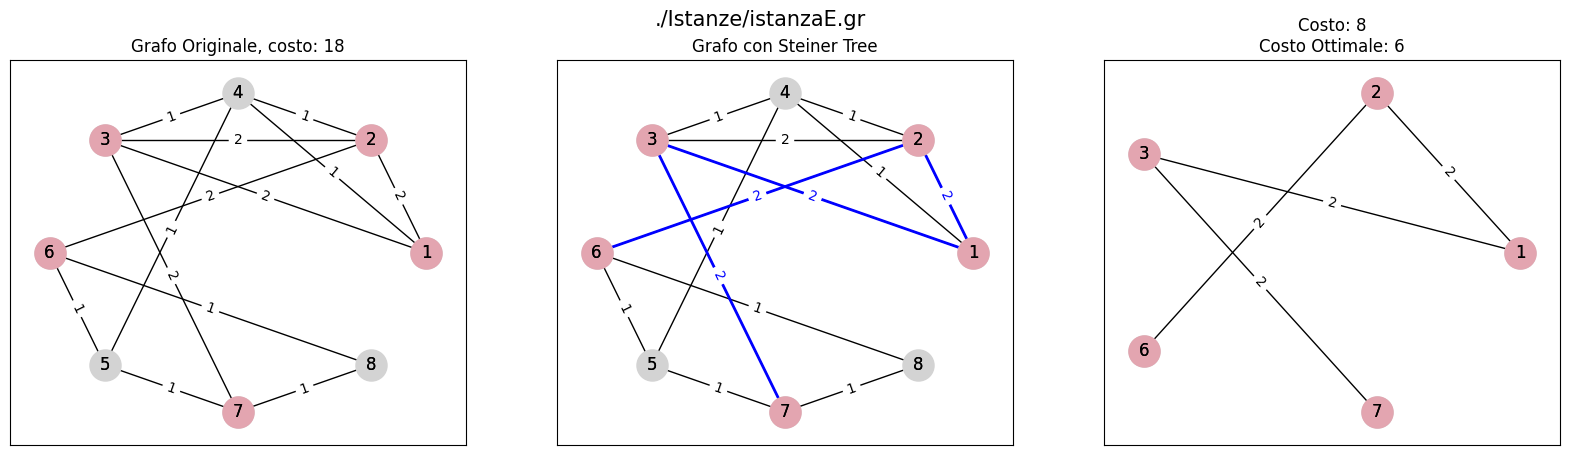

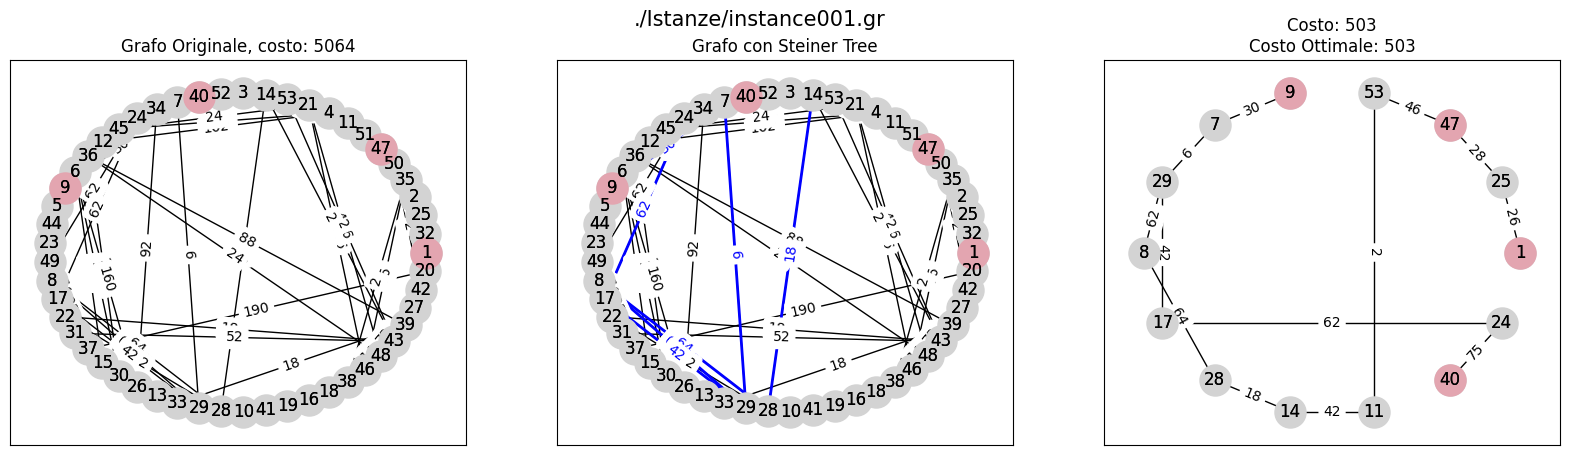

In [183]:
 
def create_graph(file_path):
    grafo = Graph()
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            line = ''
            i = 0
            #Prendo gli archi del grafo
            while True:
                line = lines[i].rstrip()
                if (line == 'END'):
                    i = i + 1
                    break
                i = i + 1
                valori = line.split()
                grafo.add_edge(valori[1], valori[2], int(valori[3]))
                
            #Prendo i vertici di steiner
            while True:
                line = lines[i].rstrip()
                if (line == 'END'):
                    i = i + 1
                    break
                i = i + 1
                valori = line.split()
                grafo.add_steiner(valori[1])
            
            #Prendo il costo ottimale del grafo
            line = lines[i].rstrip()
            grafo.set_optimal_cost_steiner_tree(line)
            
        return grafo
    except FileNotFoundError:
        print("File not found.")
    except IOError:
        print("Error reading the file.")
        
def draw_row_graph(nome_istanza, grafo, steiner_tree):
    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(1, 3, 1)# 3 righe x 5 colonne, attualmente in posizione i+1
    #Imposto il titolo dell'immagine e rimuovo gli assi
    plt.suptitle(nome_istanza, fontsize=15)
    ax.title.set_text('Grafo Originale, costo: '+ str(grafo.calculate_cost()))
    ax.set_xticks([])
    ax.set_yticks([])
    grafo.draw_graph()

    ax = fig.add_subplot(1, 3, 2)# 3 righe x 5 colonne, attualmente in posizione i+1
    #Imposto il titolo dell'immagine e rimuovo gli assi
    ax.title.set_text('Grafo con Steiner Tree')
    ax.set_xticks([])
    ax.set_yticks([])
    draw_with_steiner_tree(grafo, steiner_tree)

    ax = fig.add_subplot(1, 3, 3)# 3 righe x 5 colonne, attualmente in posizione i+1
    #Imposto il titolo dell'immagine e rimuovo gli assi
    ax.title.set_text('Costo: '+str(steiner_tree.calculate_cost())+"\nCosto Ottimale: "+str(grafo.get_optimal_cost_steiner_tree()))
    ax.set_xticks([])
    ax.set_yticks([])
    steiner_tree.draw_graph()        
        
#Lettura delle istanze da file ed esecuzione
file_path = "./Istanze/istanzaA.gr" 
grafo = create_graph(file_path)
steiner_tree = shortest_path(grafo)
draw_row_graph(file_path,grafo,steiner_tree)

file_path = "./Istanze/istanzaB.gr" 
grafo1 = create_graph(file_path)
steiner_tree1 = shortest_path(grafo1)
draw_row_graph(file_path,grafo1,steiner_tree1)

file_path = "./Istanze/istanzaC.gr" 
grafo2 = create_graph(file_path)
steiner_tree2 = shortest_path(grafo2)
draw_row_graph(file_path,grafo2,steiner_tree2)

file_path = "./Istanze/istanzaD.gr" 
grafo3 = create_graph(file_path)
steiner_tree3 = shortest_path(grafo3)
draw_row_graph(file_path,grafo3,steiner_tree3)

file_path = "./Istanze/istanzaE.gr" 
grafoE = create_graph(file_path)
steiner_treeE = shortest_path(grafoE)
draw_row_graph(file_path,grafoE,steiner_treeE)


file_path = "./Istanze/instance001.gr" 
grafo3 = create_graph(file_path)
steiner_tree3 = shortest_path(grafo3)
draw_row_graph(file_path,grafo3,steiner_tree3)

file_path = "./Istanze/instance002.gr" 
grafo3 = create_graph(file_path)
steiner_tree3 = shortest_path(grafo3)
print("\n\nIstanza: ", file_path)
print("Costo raggiunto dall'euristica:", steiner_tree3.calculate_cost())
print("Costo ottimale:", grafo3.get_optimal_cost_steiner_tree())

file_path = "./Istanze/instance006.gr" 
grafo3 = create_graph(file_path)
steiner_tree3 = shortest_path(grafo3)
print("\n\nIstanza: ", file_path)
print("Costo raggiunto dall'euristica:", steiner_tree3.calculate_cost())
print("Costo ottimale:", grafo3.get_optimal_cost_steiner_tree())

file_path = "./Istanze/instance001_t2.gr" 
grafo3 = create_graph(file_path)
steiner_tree3 = shortest_path(grafo3)
print("\n\nIstanza: ", file_path)
print("Costo raggiunto dall'euristica:", steiner_tree3.calculate_cost())
print("Costo ottimale:", grafo3.get_optimal_cost_steiner_tree())

file_path = "./Istanze/instance002_t2.gr" 
grafo3 = create_graph(file_path)
steiner_tree3 = shortest_path(grafo3)
print("\n\nIstanza: ", file_path)
print("Costo raggiunto dall'euristica:", steiner_tree3.calculate_cost())
print("Costo ottimale:", grafo3.get_optimal_cost_steiner_tree())
